## Caso de estudio 2. Sistema de tres variables de estado

Dadas las ecuaciones del motor de corriente continua con torque de carga $ T_L $ no nulo, con los parámetros:  
$$
L_{AA} = 366 \cdot 10^{-6}, \quad 
J = 5 \cdot 10^{-3}, \quad 
R_A = 55.6, \quad 
B = 0, \quad 
K_i = 6.49 \cdot 10^{-3}, \quad 
K_m = 6.53 \cdot 10^{-3}
$$

Las ecuaciones del sistema son:

$$
\frac{di_a}{dt} = -\frac{R_A}{L_{AA}} i_a - \frac{K_m}{L_{AA}} \omega + \frac{1}{L_{AA}} v_a \tag{1-5}
$$

$$
\frac{d\omega}{dt} = \frac{K_i}{J} i_a - \frac{B_m}{J} \omega - \frac{1}{J} T_L \tag{1-6}
$$

$$
\frac{d\theta_1}{dt} = \omega \tag{1-7}
$$

 

Implementar un algoritmo de simulación para inferir el comportamiento de las variables interés mediante integración de Euler con $ \Delta t = 10^{-7} $ segundos para calcular su operación con un controlador.

### Ítem [4]
Obtener el torque máximo que puede soportar el motor modelado mediante las Ecs. (1-5), (1-6) y (1-7) cuando se lo alimenta con 12V, graficando por 5 segundos de tiempo la velocidad angular y la corriente $ i_a $ para establecer su valor máximo como referencia para dimensionar dispositivos electrónicos.





In [ ]:
 !pip install SciencePlots
 

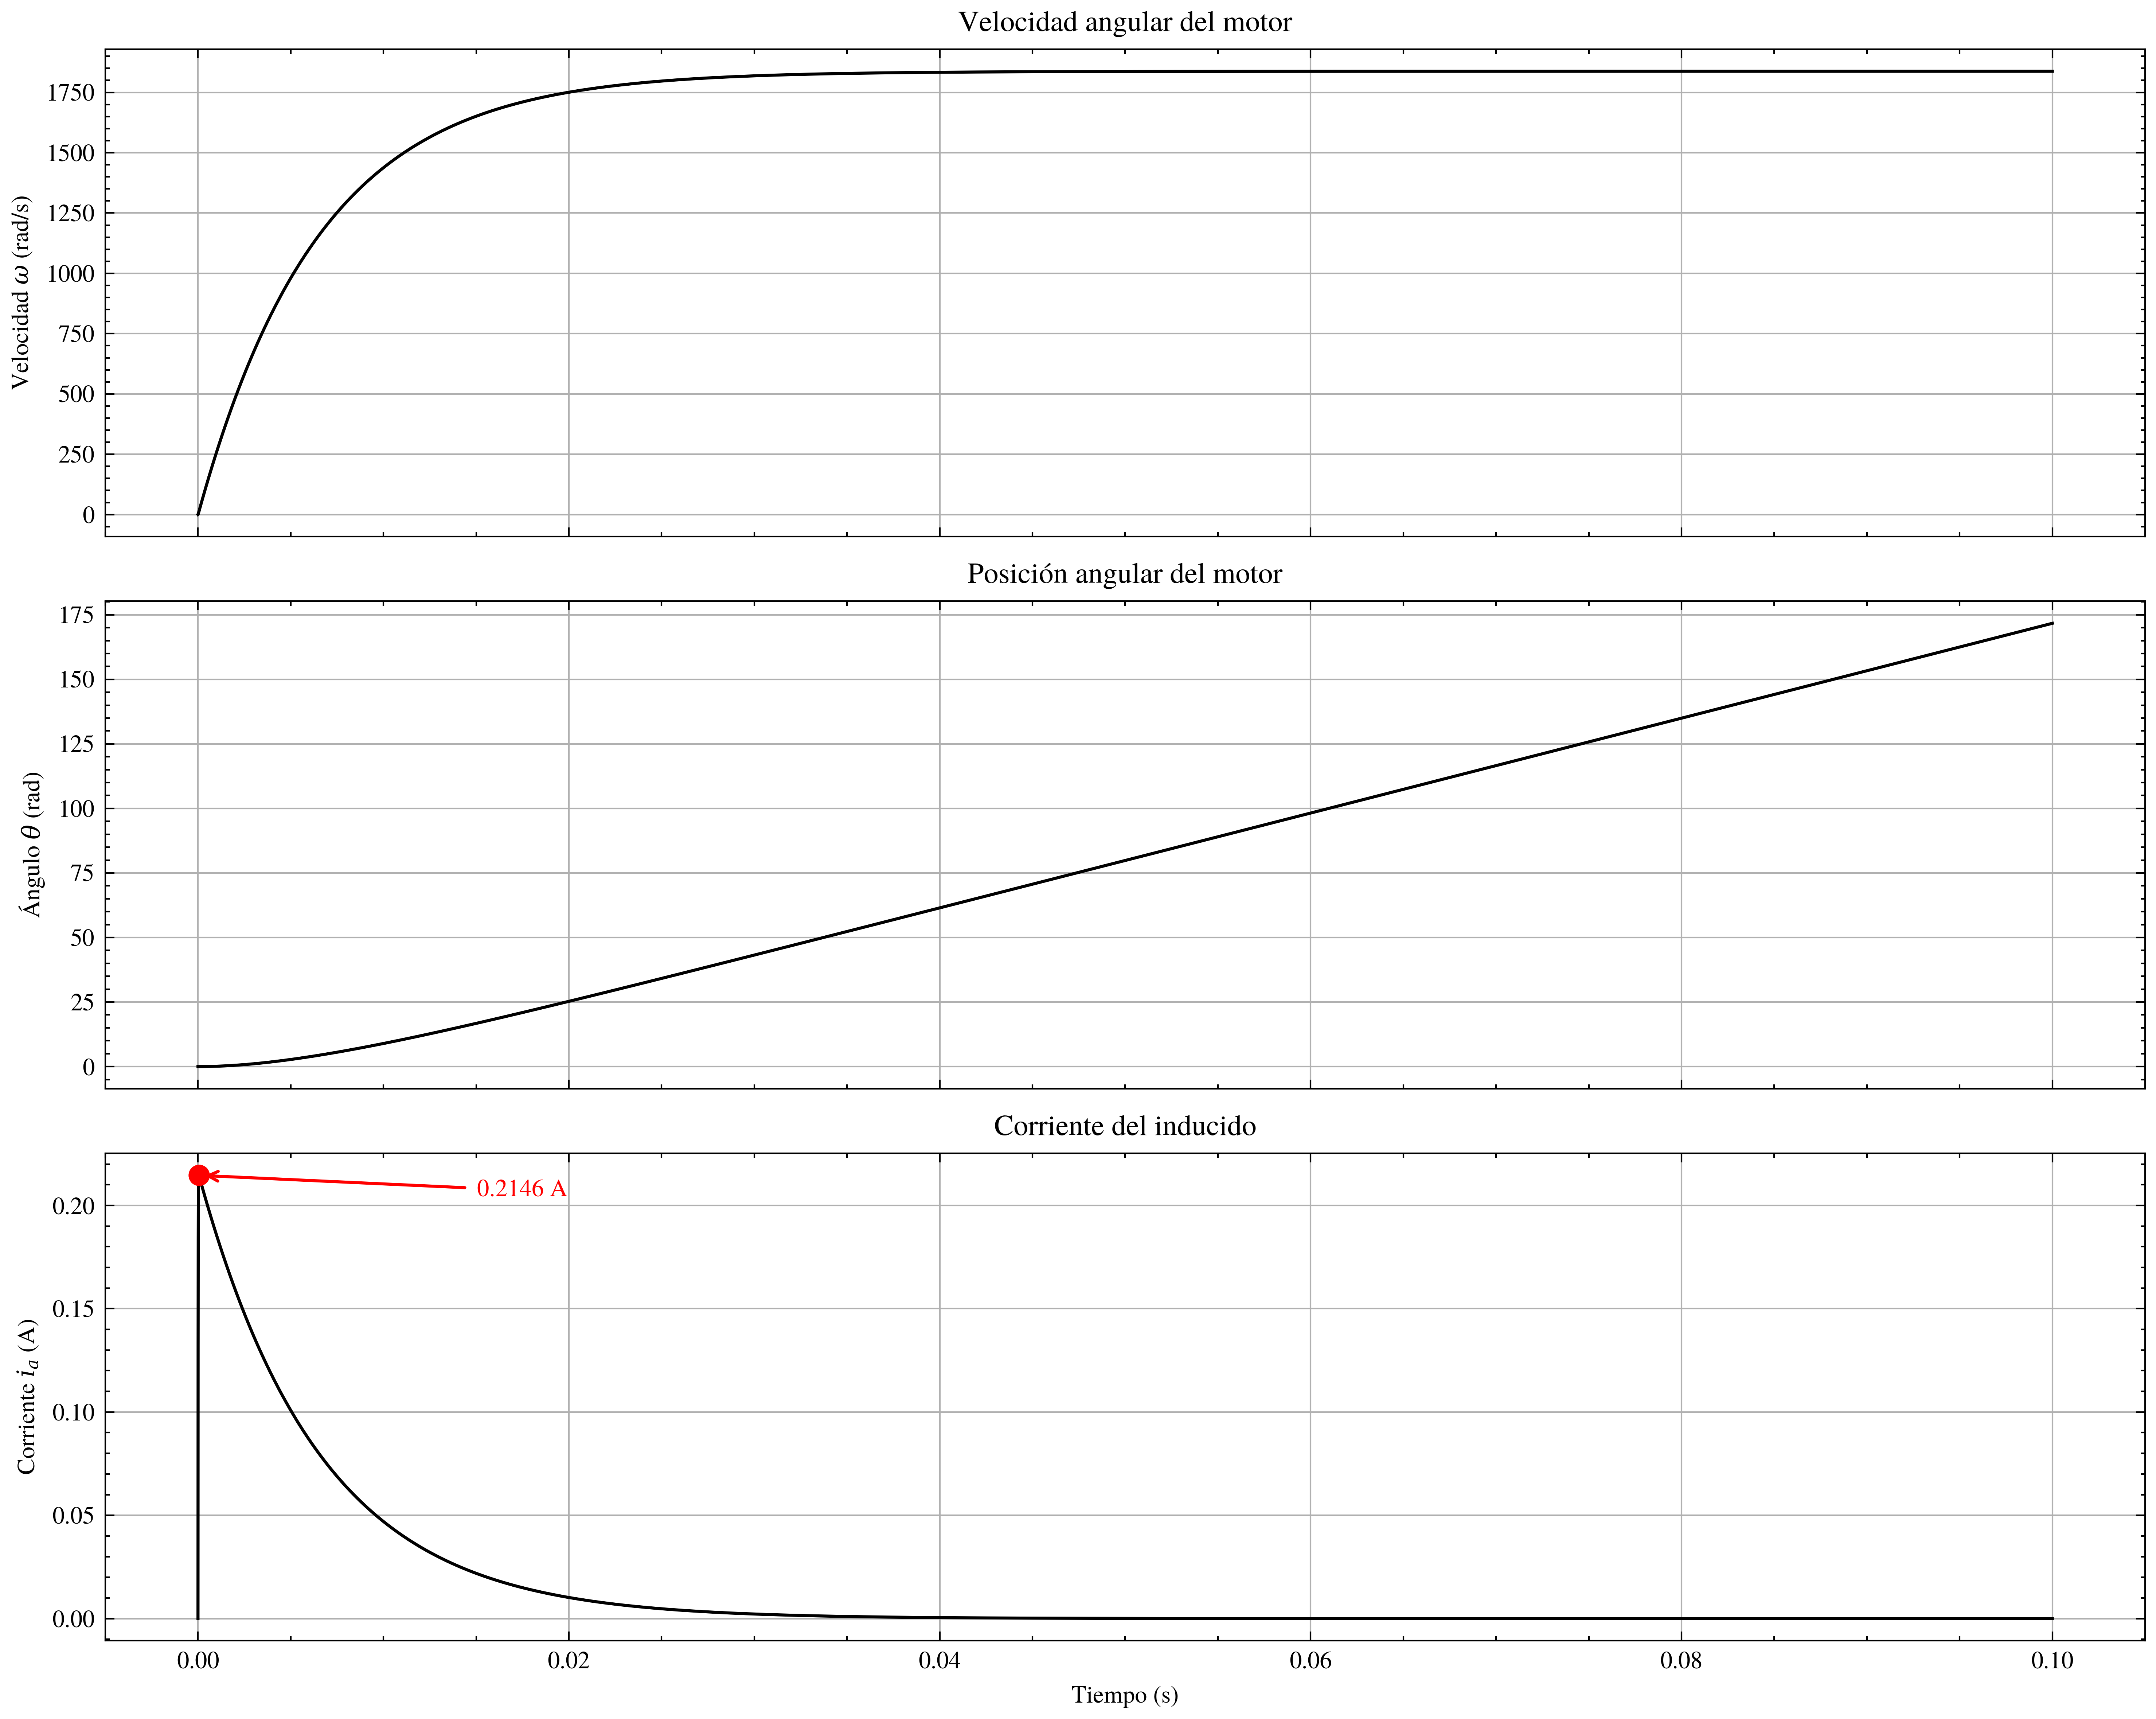

Corriente máxima alcanzada: 0.214560 A
Torque máximo alcanzado: 0.001392 Nm


In [107]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots




plt.style.use(['science', 'ieee'])  # Requiere: pip install SciencePlots
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["TeX Gyre Termes"]  # forzamos serif a usar esta
})


# ========================
# Parámetros del motor DC
# ========================
L_AA = 366e-6     # Inductancia del inducido (H)
J = 5e-9          # Momento de inercia (kg·m²)
R_A = 55.6        # Resistencia del inducido (Ohm)
B = 0             # Fricción viscosa (Nm·s)
K_i = 6.49e-3     # Constante de torque (Nm/A)
K_m = 6.53e-3     # Constante de FEM (V·s/rad)

# ========================
# Matrices del sistema
# ========================
A = np.array([
    [-R_A/L_AA, -K_m/L_AA, 0],
    [K_i/J, -B/J, 0],
    [0, 1, 0]
])

B_mat = np.array([
    [1/L_AA, 0],
    [0, -1/J],
    [0, 0]
])

# ========================
# Configuración de simulación
# ========================
dt = 1e-7               # Paso de tiempo
t_final = 0.1           # Tiempo total (s)
N = int(t_final / dt)   # Número de pasos
time = np.linspace(0, t_final, N)
v_a = 12                # Voltaje aplicado (V)
T_L = np.zeros(N)       # Torque de carga

# ========================
# Estado inicial
# ========================
x = np.zeros((3, N))  # [i_a, ω, θ]

# ========================
# Simulación por metodo de euler con variables de estado
# ========================
for k in range(N - 1):
    u = np.array([v_a, T_L[k]])  # entrada [voltaje, torque carga]
    dx = A @ x[:, k] + B_mat @ u
    x[:, k + 1] = x[:, k] + dx * dt

# ========================
# Resultados
# ========================
ia = x[0, :]
omega = x[1, :]
theta = x[2, :]
torque = K_i * ia

corriente_max = np.max(ia)
torque_max = np.max(torque)

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Velocidad angular
axs[0].plot(time, omega, color='black')
axs[0].set_ylabel("Velocidad $\\omega$ (rad/s)")
axs[0].set_title("Velocidad angular del motor")
axs[0].grid()

# Posición angular
axs[1].plot(time, theta, color='black')
axs[1].set_ylabel("Ángulo $\\theta$ (rad)")
axs[1].set_title("Posición angular del motor")
axs[1].grid()

# Corriente
axs[2].plot(time, ia, color='black')
axs[2].set_xlabel("Tiempo (s)")
axs[2].set_ylabel("Corriente $i_a$ (A)")
axs[2].set_title("Corriente del inducido")
axs[2].grid()

# Marcar la corriente máxima
corriente_max_idx = np.argmax(ia)
axs[2].plot(time[corriente_max_idx], corriente_max, 'ro')
axs[2].annotate(f'{corriente_max:.4f} A',
                xy=(time[corriente_max_idx], corriente_max),
                xytext=(time[corriente_max_idx] + 0.015, corriente_max - 0.01),
                arrowprops=dict(arrowstyle="->", color='red'),
                color='red')

plt.tight_layout()
plt.show()

# ========================
# Resultado final
# ========================
print(f"Corriente máxima alcanzada: {corriente_max:.6f} A")
print(f"Torque máximo alcanzado: {torque_max:.6f} Nm")


### Ítem [5]
A partir de las curvas de mediciones de las variables graficadas en la Fig. 1-3, se requiere obtener el modelo del sistema considerando como entrada un escalón de 12V, como salida la velocidad angular, y el torque de carga $T_L $ aplicado como una perturbación.  
En el archivo `Curvas_Medidas_Motor_2025.xls` están las mediciones: en la primera hoja los valores, y en la segunda los nombres.  
Se requiere obtener el modelo dinámico para establecer las constantes del modelo (1-5), (1-6).


El primer paso es cargar los datos desde el excel y luego graficar las curvas. Para mi caso particular, extraje los datos desde el excel y los guarde en un csv, para facilitar la lectura.

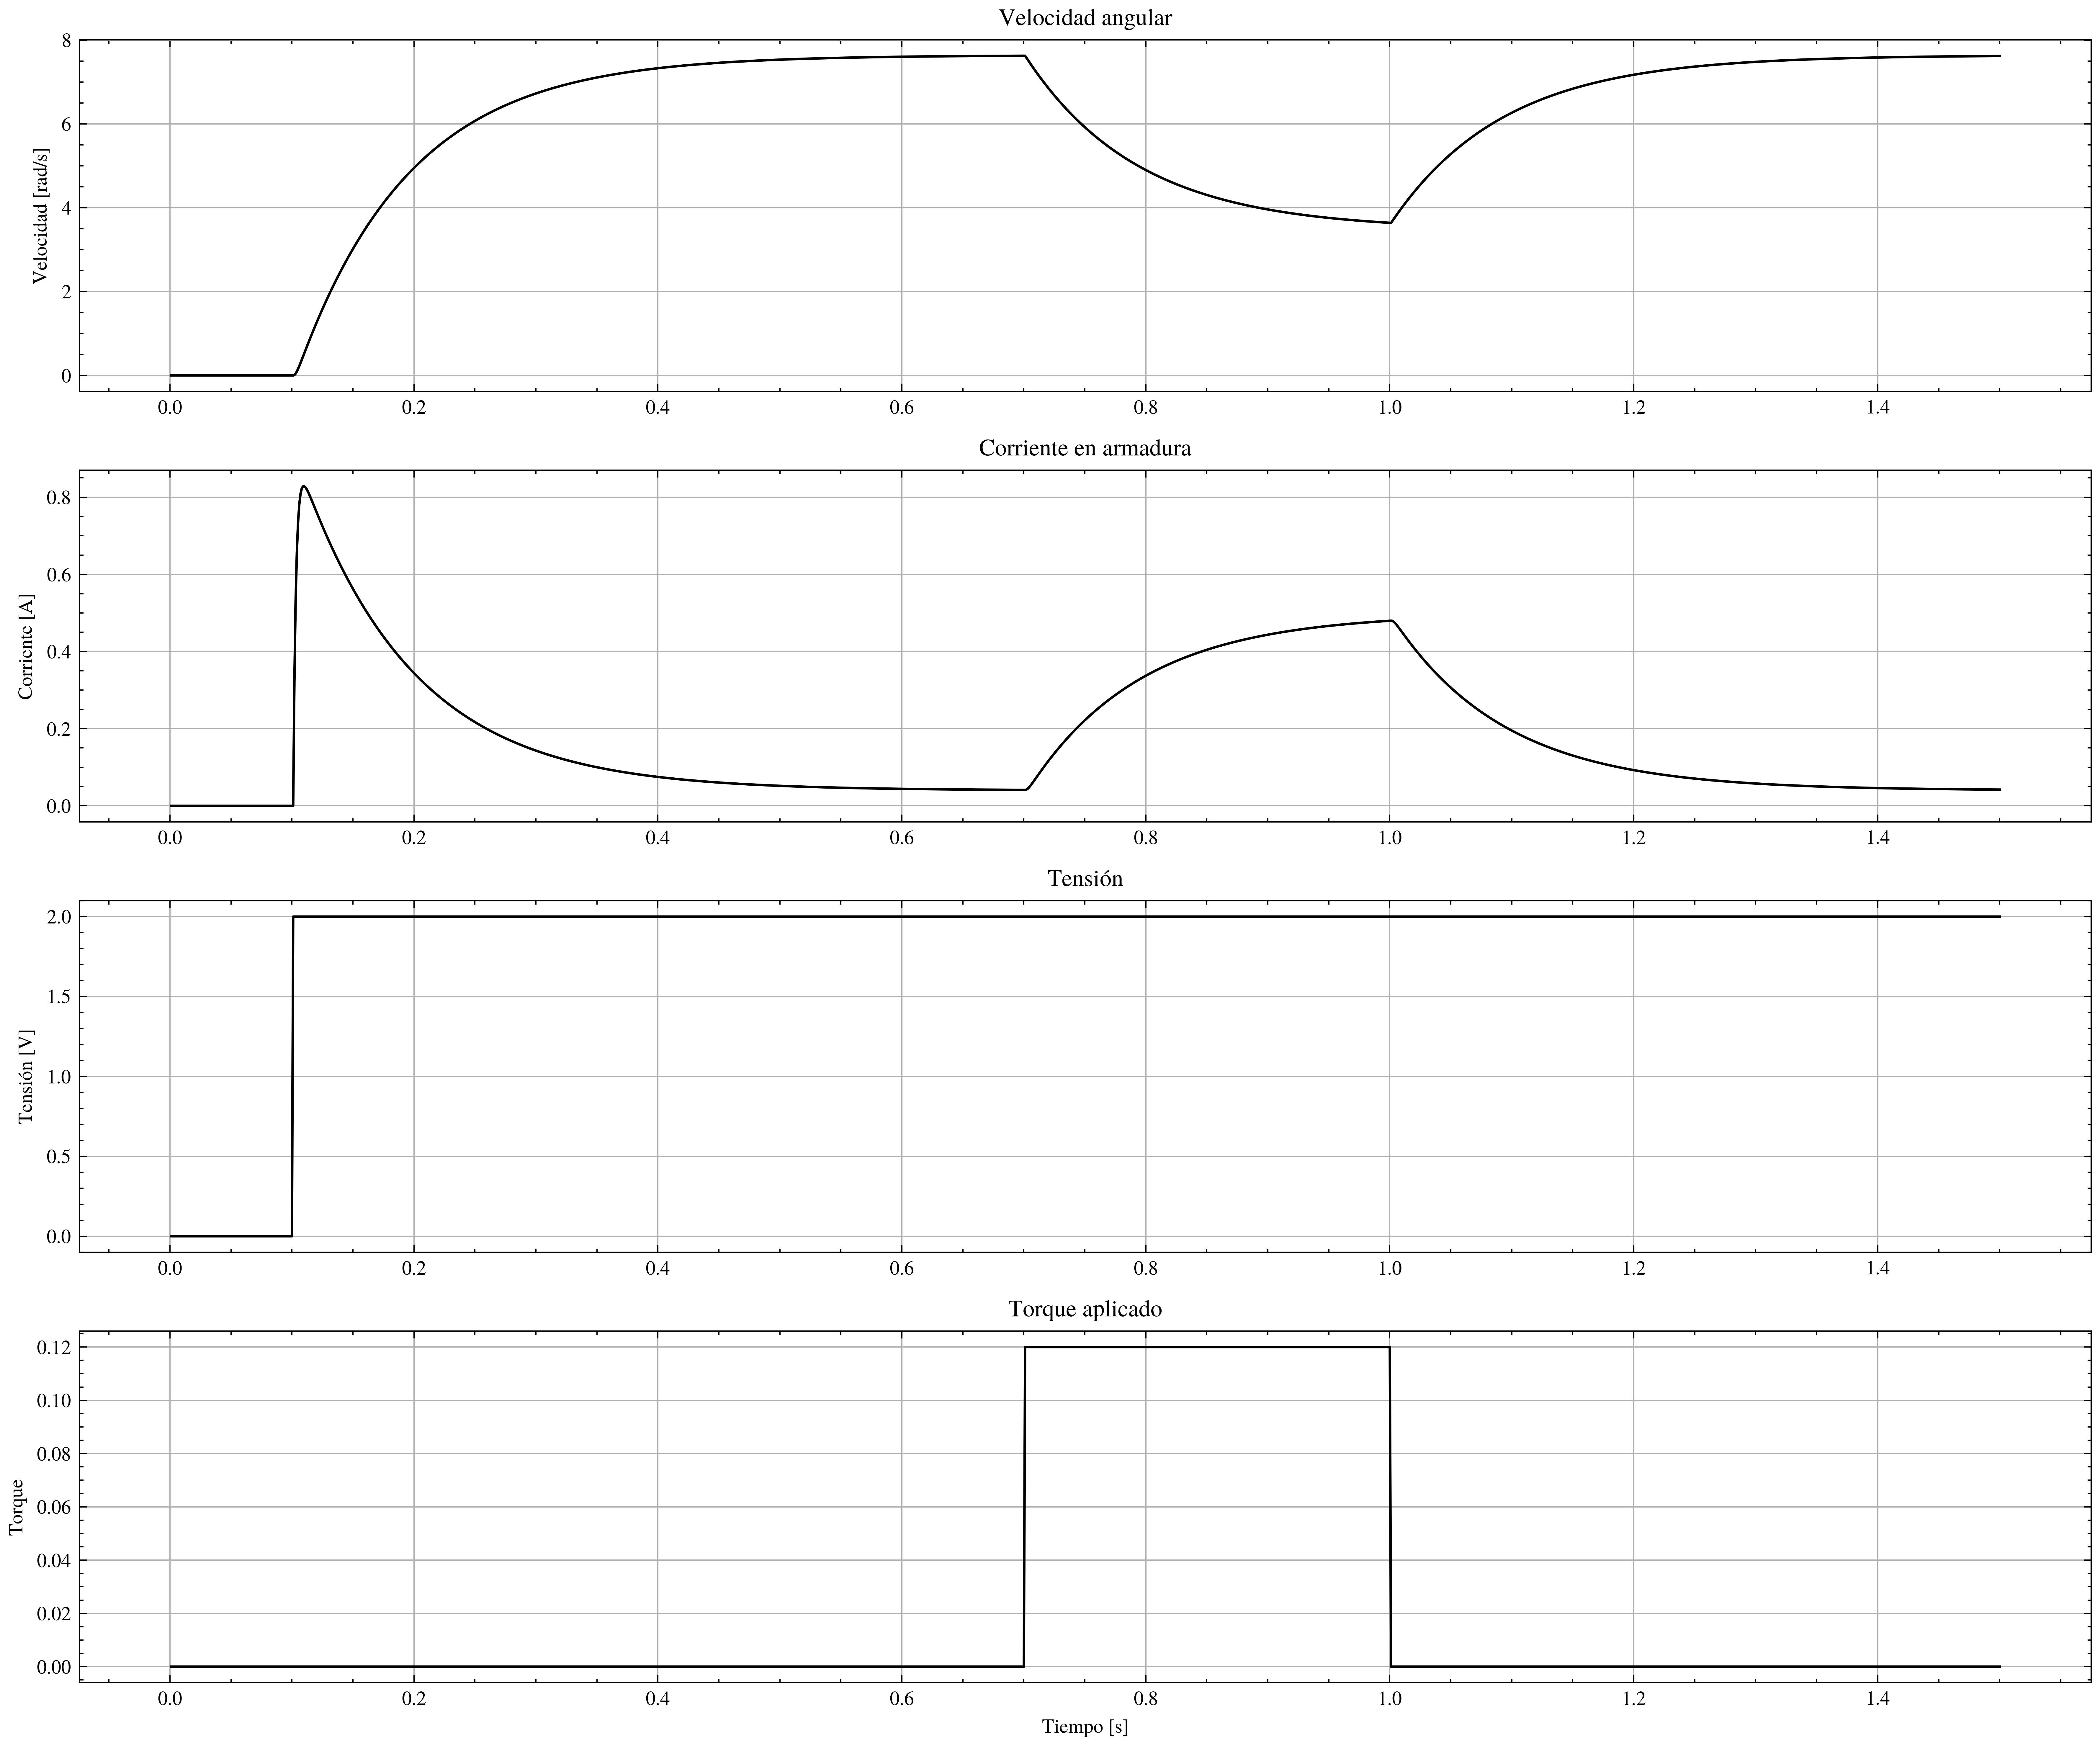

In [114]:
import pandas as pd

# Cargar datos desde el excel
df = pd.read_csv("data/Curvas_Medidas_Motor_2025v.csv")

df.columns = [col.strip() for col in df.columns]  # eliminar espacios

# Crear gráficos
plt.figure(figsize=(12, 10))

# Gráfico 1: Velocidad angular vs Tiempo
plt.subplot(4, 1, 1)
plt.plot(df['Tiempo [Seg.]'], df['Velocidad angular [rad /seg]'], color='black')
plt.title('Velocidad angular')
plt.ylabel('Velocidad [rad/s]')
plt.grid(True)

# Gráfico 2: Corriente en armadura vs Tiempo
plt.subplot(4, 1, 2)
plt.plot(df['Tiempo [Seg.]'], df['Corriente en armadura [A]'], color='black')
plt.title('Corriente en armadura')
plt.ylabel('Corriente [A]')
plt.grid(True)

# Gráfico 3: Tensión vs Tiempo
plt.subplot(4, 1, 3)
plt.plot(df['Tiempo [Seg.]'], df['Tensión [V]'], color='black')
plt.title('Tensión')
plt.ylabel('Tensión [V]')
plt.grid(True)

# Gráfico 4: Torque vs Tiempo
plt.subplot(4, 1, 4)
plt.plot(df['Tiempo [Seg.]'], df['Torque'], color='black')
plt.title('Torque aplicado')
plt.xlabel('Tiempo [s]')
plt.ylabel('Torque')
plt.grid(True)

plt.tight_layout()
plt.show()


Ahora para poder identificar el modelo, aplicando el metodo de "Lei Chen", debemos obtener los puntos de la curva de velocidad angular vs tiempo. Tres puntos equidistantes en el tiempo, durante la etapa transitoria (y cuando el torque de carga es nulo). Y tambien tres puntos equidistantes en el tiempo, cuando el torque de carga es no nulo.

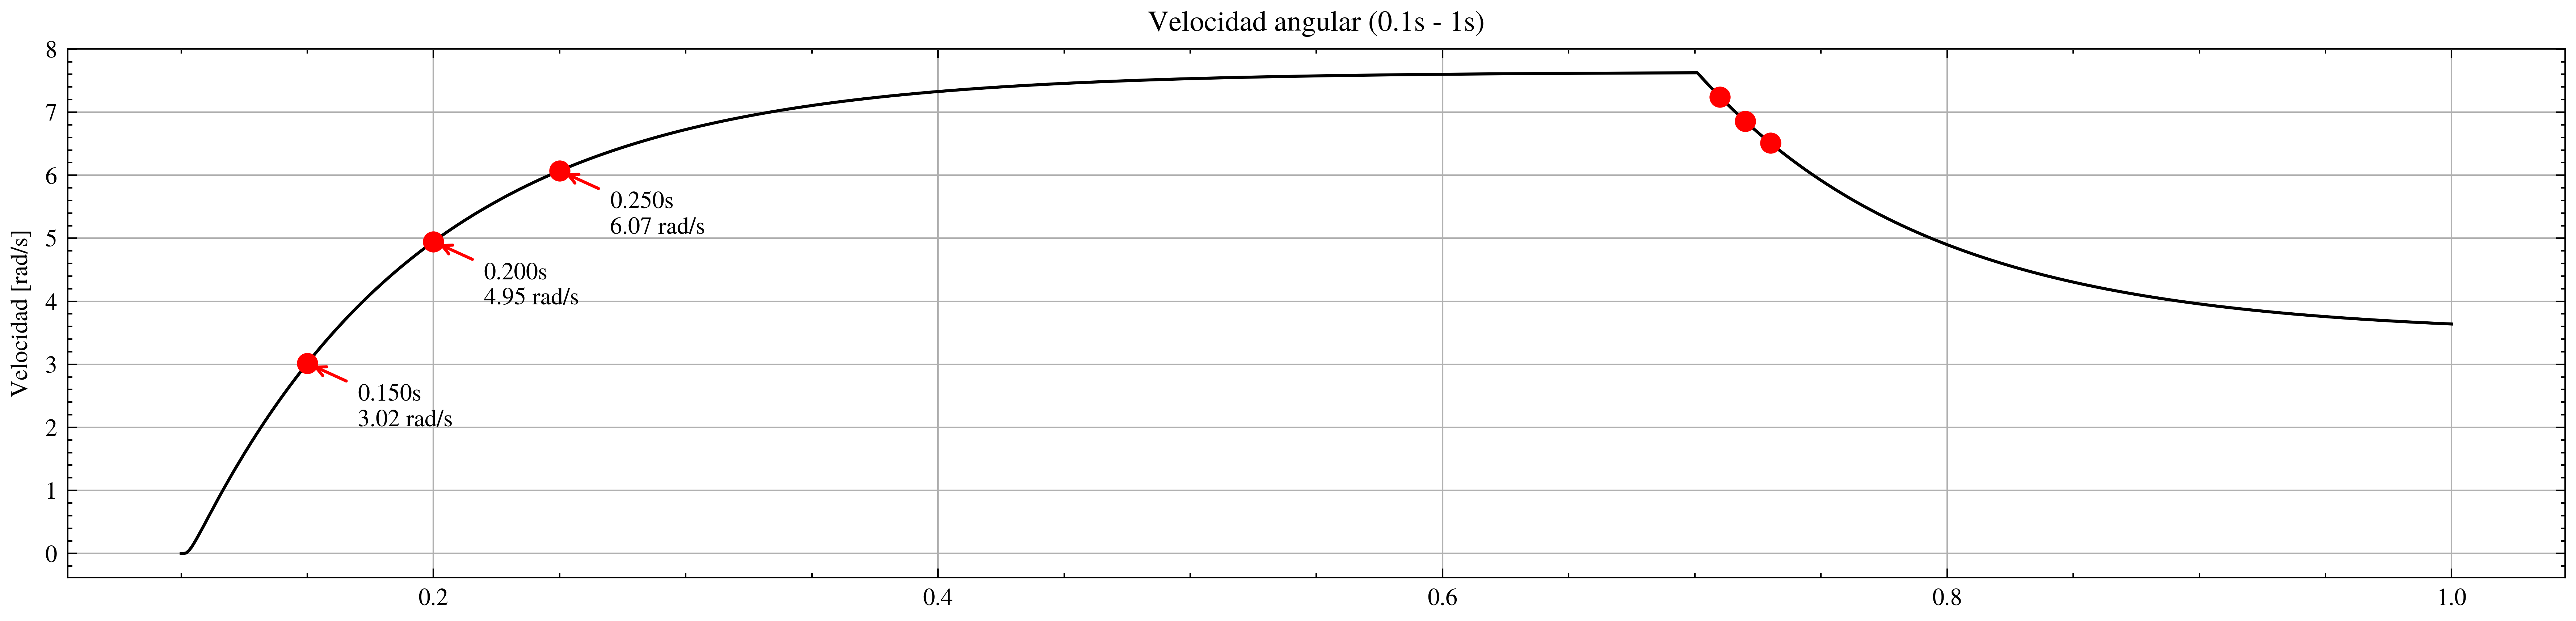

In [124]:
# definimos una ventana de visualización
tiempo_min = 0.1
tiempo_max = 1

# definimos los puntos equidistantes en el tiempo para la velocidad respecto a la tension
delay_tension = 0.1
t1_rel = 0.05;
tiempos_relativos_tension = [t1_rel, 2*t1_rel, 3*t1_rel]
tiempos_absolutos_tension  = [t + delay_tension for t in tiempos_relativos_tension] # desplazamos los puntos en el tiempo

# definimos los puntos equidistantes en el tiempo para la velocidad respecto al torque
delay_torque = 0.7
t1_rel = 0.01;
tiempos_relativos_torque = [t1_rel, 2*t1_rel, 3*t1_rel]
tiempos_absolutos_torque = [t + delay_torque for t in tiempos_relativos_torque] # desplazamos los puntos en el tiempo 

# Filtrar datos por ventana de tiempo
df_filtrado = df[(df['Tiempo [Seg.]'] >= tiempo_min) & (df['Tiempo [Seg.]'] <= tiempo_max)]

# Generamos la gráfica marcando los puntos seleccionados
def plot_selected_points(dataframe, puntos_tension, puntos_torque):
    
    plt.figure(figsize=(12, 3))

    plt.plot(dataframe['Tiempo [Seg.]'], dataframe['Velocidad angular [rad /seg]'], color='black')
    
      # graficamos los puntos con torque nulo
    for t in puntos_tension:
        idx = dataframe['Tiempo [Seg.]'].sub(t).abs().idxmin()
        valor = dataframe.loc[idx, 'Velocidad angular [rad /seg]']
        plt.plot(t, valor, 'ro')
        # Añadir texto apuntando al punto
        plt.annotate(f'{t:.3f}s\n{valor:.2f} rad/s', 
                     xy=(t, valor), 
                     xytext=(t+0.02, valor-1),  # Posición TEXTO
                     arrowprops=dict(arrowstyle='->', color='red'),
                     fontsize=8)
    
    # graficamos los puntos con torque no nulo
    for t in puntos_torque:
        idx = dataframe['Tiempo [Seg.]'].sub(t).abs().idxmin()  
        valor = dataframe.loc[idx, 'Velocidad angular [rad /seg]']
        plt.plot(t, valor, 'ro')
    #    plt.annotate(f'{t:.3f}s\n{valor:.2f} rad/s',
    #                 xy=(t, valor), xytext=(t-0.0809, valor-t-0.5),
    #                 arrowprops=dict(arrowstyle='->', color='red'), fontsize=8)
    
    plt.title(f'Velocidad angular ({tiempo_min}s - {tiempo_max}s)')
    plt.ylabel('Velocidad [rad/s]')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Ejecutar gráfica con puntos seleccionados
plot_selected_points(df_filtrado, tiempos_absolutos_tension, tiempos_absolutos_torque)


Una vez obtenidos los puntos, procedemos a identificar el modelo. Para esto definimos una función que implementa el metodo de Chen de forma generalizada (corrige los retardos si los tiene y la amplitud si el escalon no es unitario)

In [116]:
# ========================
# FUNCION PARA IDENTIFICAR LOS PARAMETROS POR METODO DE CHEN
# ========================
def obtener_parametros_por_metodo_chen(t_sel_relativos, retardo, tiempo,  respuesta,  amplitud_escalon, y_final):
    """
    Método de Chen para estimar k, T1, T2 y T3 de un sistema de 2º orden.
    
    Parámetros
    ----------
    t_sel_relativos 
        Array con los tiempos relativos t1, t2, t3 seleccionados.
    retardo : float
        Retardo de sistema. 0 si no hay retardo.
    tiempo
        Vector de tiempos de las mediciones.
    respuesta
        Vector de la respuesta al escalón de las mediciones.
    amplitud_escalon : float
        Amplitud del escalón aplicado.
    y_final : float
        Valor final estacionario de la respuesta.

    Devuelve
    -------
    k, T1, T2, T3 : 
        Ganancia y constantes de tiempo.
    """
    
    
    # 1. Hacemos una correccion en caso que el tiempo (t1, t2, t3) seleccionado de las mediciones no exista en 
    # el vector de tiempo. Entonces se toma el valor mas cercano. Y obtenemos los indices de los mismos. 
    
    t_mediciones = [t + retardo for t in t_sel_relativos] 
    # idxs = np.abs(tiempo[:, None] - t_mediciones[None, :]).argmin(axis=0)
    idxs = [np.argmin(np.abs(tiempo - t)) for t in t_mediciones] # más legible
    
    # 2. Extraer valores y1, y2, y3
    t1 = tiempo[idxs[0]] - retardo
    y1, y2, y3  = respuesta[idxs]  # [y1, y2, y3]

    # 3. 
    k = y_final / amplitud_escalon 
    
    k1 = (y1 / (amplitud_escalon * k)) - 1
    k2 = (y2 / (amplitud_escalon * k)) - 1
    k3 = (y3 / (amplitud_escalon * k)) - 1

    # 5. Discriminante
    b = 4*k1**3*k3 - 3*k1**2*k2**2 - 4*k2**3 + k3**2 + 6*k1*k2*k3
    # Si b<0 consideramos parte real o bien avisamos
    if b < 0:
        print(f" Los polos pueden ser complejos")
        b = np.real(b) # convertimos a real


    sqrt_b = np.sqrt(b) 
    denom = 2*(k1**2 + k2)
    alfa1 = (k1*k2 + k3 - sqrt_b) / denom
    alfa2 = (k1*k2 + k3 + sqrt_b) / denom
    beta = ((2*k1**3 + 3*k1*k2 + k3 - sqrt_b) / sqrt_b
            if sqrt_b != 0 else 0.0)  # si sqrt_b es 0, beta es 0, para evitar indeterminacion

    # 6. Constantes de tiempo
    T1 = np.real(-t1 / np.log(abs(alfa1)))
    T2 = np.real(-t1 / np.log(abs(alfa2)))
    T3 = np.real(beta*(T1 - T2) + T1)

    return k, T1, T2, T3

Ahora procedemos a identificar los parametros de la función de transferencia: Velocidad / Tensión

In [117]:
from scipy.signal import lsim, TransferFunction
# cargamos los datos medidos
tiempos = df["Tiempo [Seg.]"].values
salidas = df["Velocidad angular [rad /seg]"].values
 


# ================================
# Estimación de la F.T. = Velocidad / Tensión
# ================================

amplitud_tension = 2     # Escalón de tensión [V]

# usamos directamente la salida medida, sin ajustar
salida_tension = salidas

# Estimación de estado estacionario para tensión
mask_estacionario = (tiempos >= 0.6) & (tiempos <= 0.7)
y_final_tension = salidas[mask_estacionario].mean()


# Tensión -> Velocidad
k_va, T1_va, T2_va, T3_va = obtener_parametros_por_metodo_chen(
    tiempos_relativos_tension, delay_tension, tiempos, salida_tension, amplitud_tension, y_final_tension
)
# === Mostrar resultados ===

print("\n--- PARÁMETROS IDENTIFICADOS ---")
print(f"Tensión -> Velocidad:")
print(f"  K = {k_va:.4f}")
print(f"  T1 = {T1_va:.6f} s")
print(f"  T2= {T2_va:.6f} s")

# Velocidad por tensión
sistema_va = TransferFunction([k_va], np.convolve([T1_va, 1], [T2_va, 1]))

# mostramos de forma amigable 
sistema_va


--- PARÁMETROS IDENTIFICADOS ---
Tensión -> Velocidad:
  K = 3.8075
  T1 = 0.015142 s
  T2= 0.091430 s


TransferFunctionContinuous(
array([2750.21230718]),
array([  1.        ,  76.97948098, 722.32213325]),
dt: None
)

Ahora procedemos a identificar los parametros de la función de transferencia: Velocidad / Torque

In [118]:
# ================================
# Estimación de la F.T. = Velocidad / Torque
# ================================

amplitud_torque = 0.12 # Escalón de torque [Nm]
velocidad_offset = 7.625   # Velocidad estacionaria previa al cambio de torque

# === Tratamiento de señales para adaptar al metodo chen ===
# ajuste de la salida para representar la contribución del torque 
salida_torque = -(salidas - velocidad_offset)


# Estimación del estado estacionario para torque 
y_torque_estacionario = 3.638 # Obtenemos observando la gráfica
y_final_torque = -(y_torque_estacionario - y_final_tension)


# Torque -> Velocidad
k_torque, T1_torque, T2_torque, T3_torque = obtener_parametros_por_metodo_chen(
    tiempos_relativos_torque, delay_torque, tiempos, salida_torque, amplitud_torque, y_final_torque
)

# === Mostrar resultados === 
print(f"\nTorque -> Velocidad:")
print(f"  K = {k_torque:.4f}")
print(f"  T1 = {T1_torque:.6f} s")
print(f"  T2 = {T2_torque:.6f} s")

 
sistema_torque = TransferFunction(k_torque, np.convolve([T1_torque, 1], [T2_torque, 1]))

sistema_torque



Torque -> Velocidad:
  K = 33.1410
  T1 = 0.003305 s
  T2 = 0.087455 s


TransferFunctionContinuous(
array([114643.92724579]),
array([1.00000000e+00, 3.13966414e+02, 3.45927863e+03]),
dt: None
)

Finalmente,  finalizamos realizamos las simulaciones y comparamos:

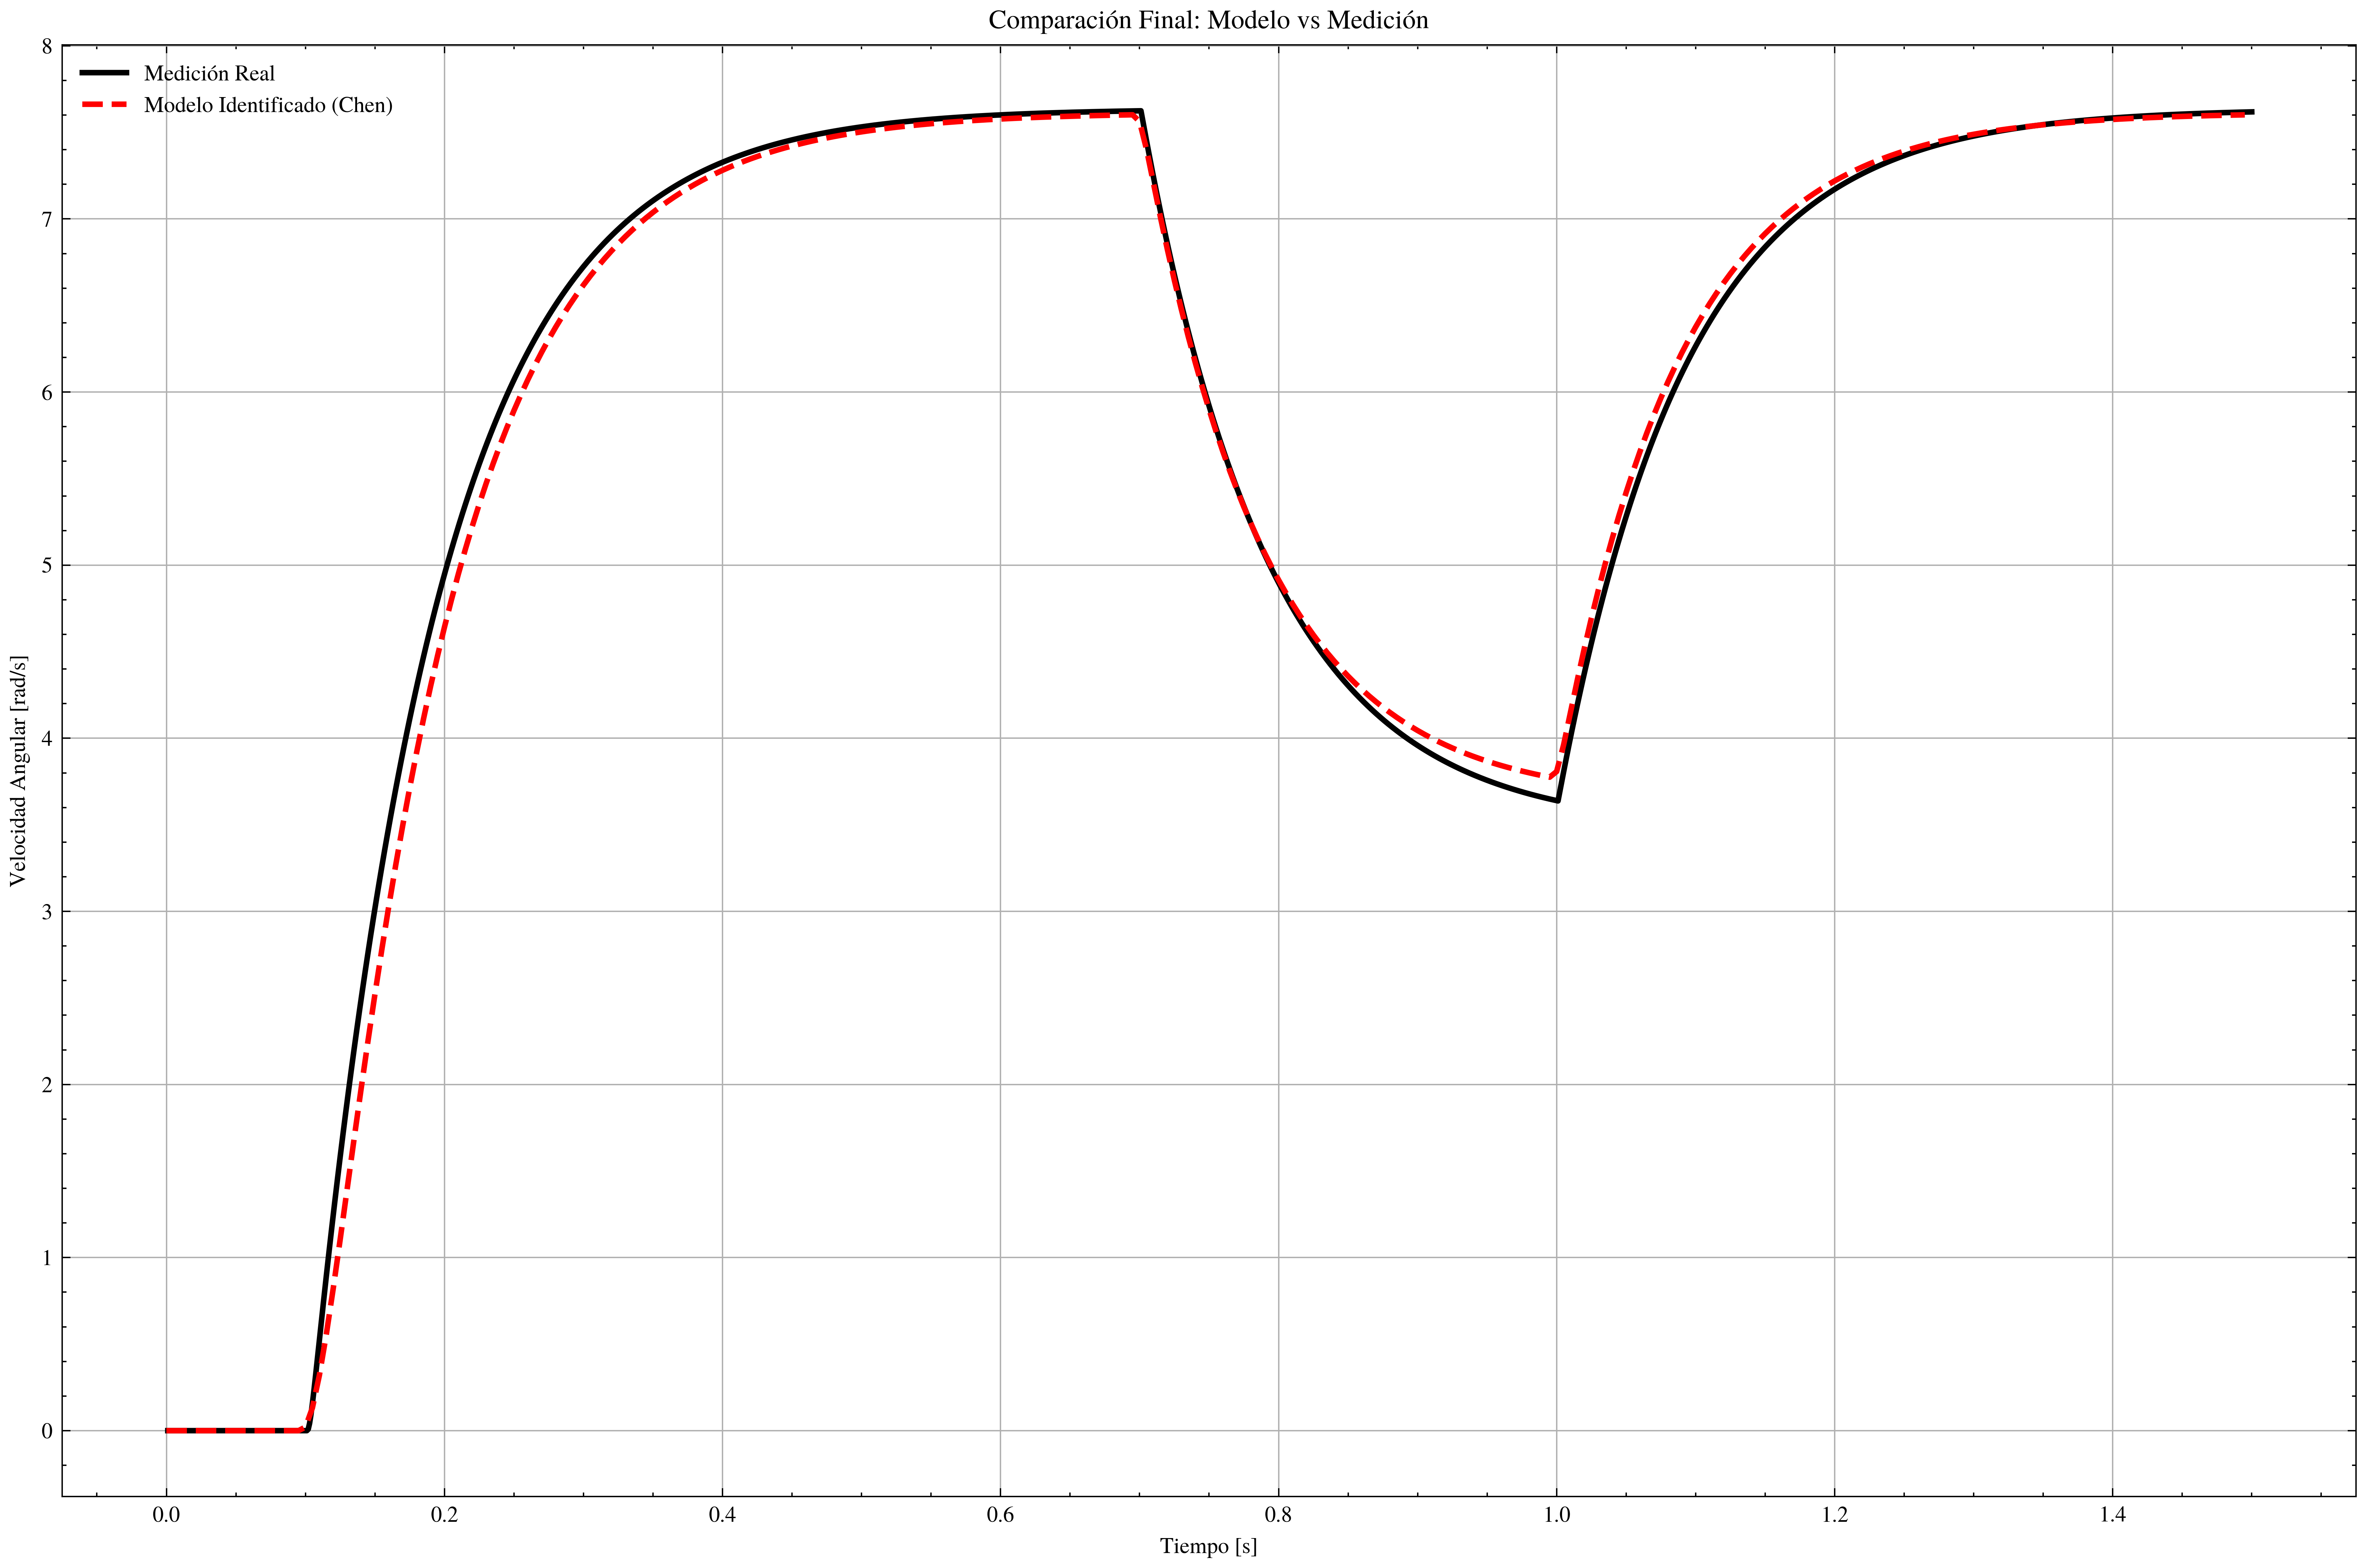

In [119]:
# === Simulación ===

# Configuración de tiempo de simulación
dt = 0.005
t_sim = np.arange(0, 1.5, dt)
# Entradas
entrada_tension = np.zeros_like(t_sim)
entrada_torque = np.zeros_like(t_sim)

# Escalones aplicados
idx_retardo = int(delay_tension / dt)
idx_inicio_torque = int(delay_torque / dt)  # Torque empieza en este indice 
idx_fin_torque = int(1 / dt) # Finaliza en este indice, el num se obtiene observando


entrada_tension[idx_retardo:] = amplitud_tension  # Escalón de tensión

entrada_torque[idx_inicio_torque:idx_fin_torque] = amplitud_torque  # Escalón de torque

# Simulación de respuestas 

t_out, y_tension, _ = lsim(sistema_va,    U=entrada_tension, T=t_sim)
t_out, y_torque,  _ = lsim(sistema_torque, U=entrada_torque,  T=t_sim)

y_total = y_tension - y_torque
# === Gráficas ===

plt.figure(figsize=(12, 8))
plt.plot(tiempos, salidas, label="Medición Real", linewidth=2)
plt.plot(t_sim, y_total, label="Modelo Identificado (Chen)", linewidth=2)
plt.title("Comparación Final: Modelo vs Medición")
plt.xlabel("Tiempo [s]")
plt.ylabel("Velocidad Angular [rad/s]")
plt.legend()
plt.grid(True)
#plt.xlim(159, 175)
plt.tight_layout()
plt.show()

Procedemos a identificar la funcion de transferencia $i_a / v_a$ 


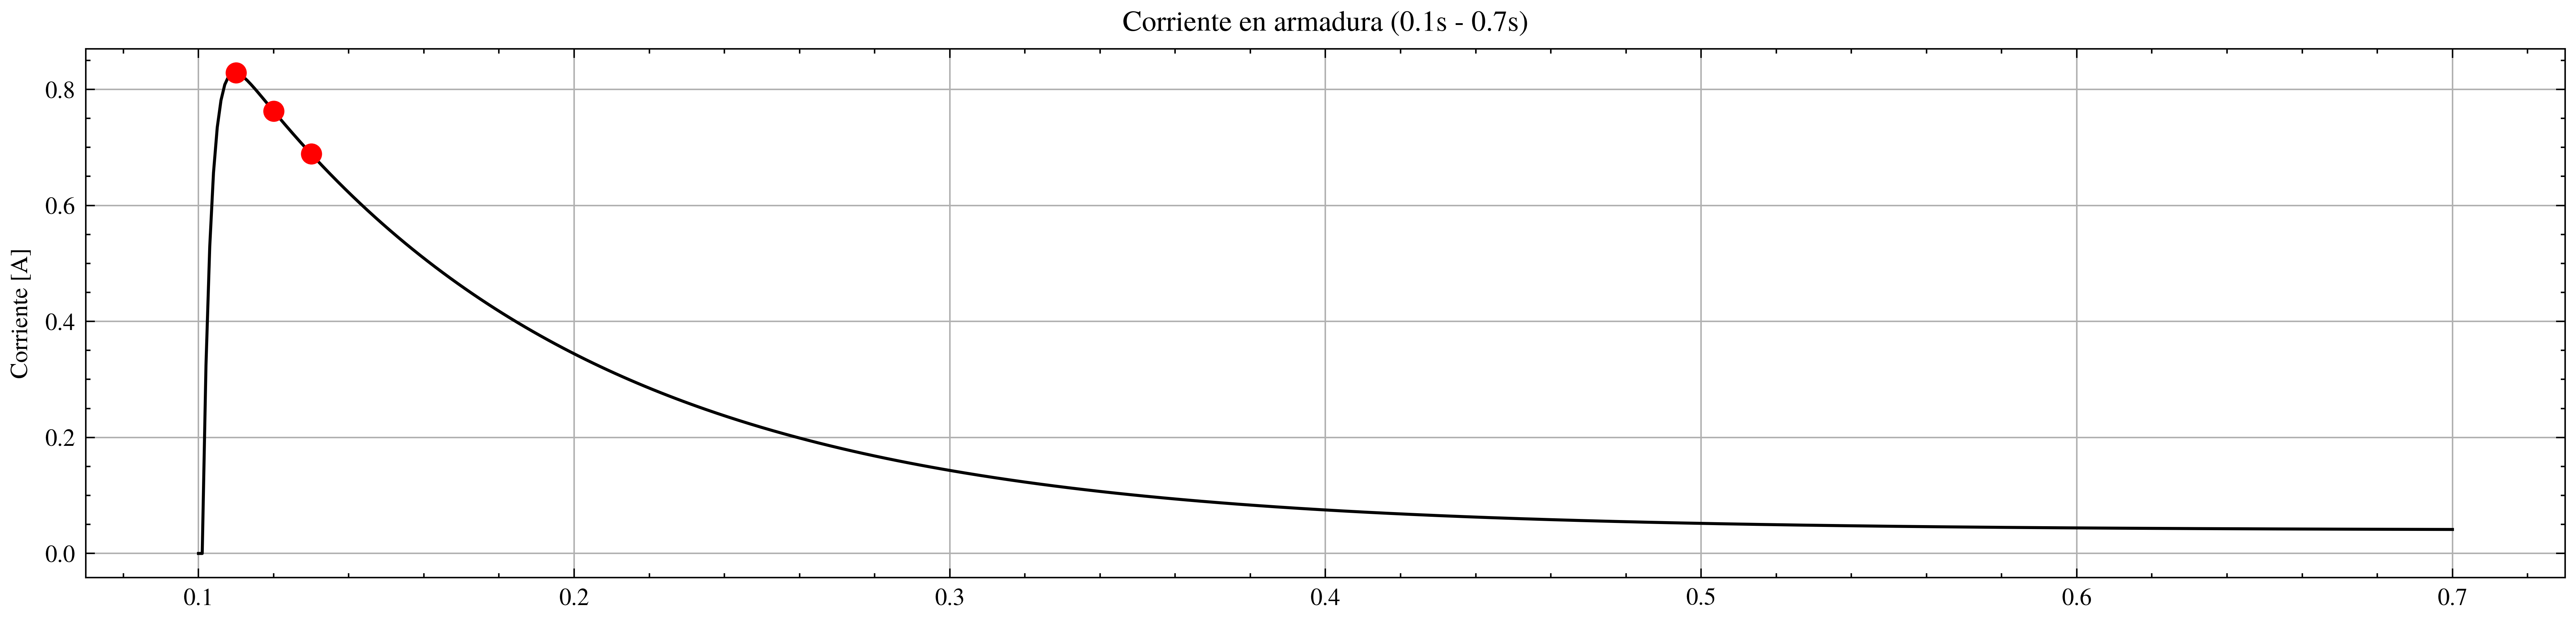

In [151]:
# ================================
# Estimación de la F.T. = Corriente / Tensión
# ================================

# utilizamos esta ventana de tiempo para obtener los puntos de la curva de corriente respecto a la tension de entrada 
# definidos anteriormente
tiempo_min = 0.1
tiempo_max = 0.7
 
# reutilizamos el vector de tiempo anteriormente definido
salidas = df["Corriente en armadura [A]"].values
# para la entrada, utilizamos los vectores ya creados mas arriba, entrada_tension y entrada_torque
# Filtrar datos por ventana de tiempo
df_filtrado = df[(df['Tiempo [Seg.]'] >= tiempo_min) & (df['Tiempo [Seg.]'] <= tiempo_max)]

y_final_tension = df_filtrado["Corriente en armadura [A]"].max()

amplitud_tension = 2     # Escalón de tensión [V]

# obtenemos el lugar de t1, que es el punto mas cercano a la corriente final (maximo de la corriente)
lugar_t1 = np.argmin(np.abs(y_final_tension - df_filtrado["Corriente en armadura [A]"].values))

# definimos los puntos equidistantes en el tiempo para la velocidad respecto a la tension
delay_tension = 0.1
t1_rel = df_filtrado["Tiempo [Seg.]"].iloc[lugar_t1] - delay_tension

tiempos_relativos_tension = [t1_rel, 2*t1_rel, 3*t1_rel]
tiempos_absolutos_tension  = [t + delay_tension for t in tiempos_relativos_tension] # desplazamos los puntos en el tiempo
 

# Generamos la gráfica marcando los puntos seleccionados
def plot_selected_points(dataframe, puntos_tension, puntos_torque):
    
    plt.figure(figsize=(12, 3))

    plt.plot(dataframe['Tiempo [Seg.]'], dataframe['Corriente en armadura [A]'], color='black')
    
      # graficamos los puntos con torque nulo
    for t in puntos_tension:
        idx = dataframe['Tiempo [Seg.]'].sub(t).abs().idxmin()
        valor = dataframe.loc[idx, 'Corriente en armadura [A]']
        plt.plot(t, valor, 'ro')
        
    
    plt.title(f'Corriente en armadura ({tiempo_min}s - {tiempo_max}s)')
    plt.ylabel('Corriente [A]')
    plt.grid(True)

    plt.tight_layout()
    plt.show()




# Ejecutar gráfica con puntos seleccionados
plot_selected_points(df_filtrado, tiempos_absolutos_tension, tiempos_absolutos_torque)








Utilizamos el metodo de Chen para identificar los parametros de la funcion de transferencia $i_a / v_a$

Corriente/Va:
  K = 0.0104
  T1 = 0.002483 s
  T2 = 0.094922 s
<TransferFunction>: sys[34]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


          0.0104 s
----------------------------
0.0002357 s^2 + 0.0974 s + 1



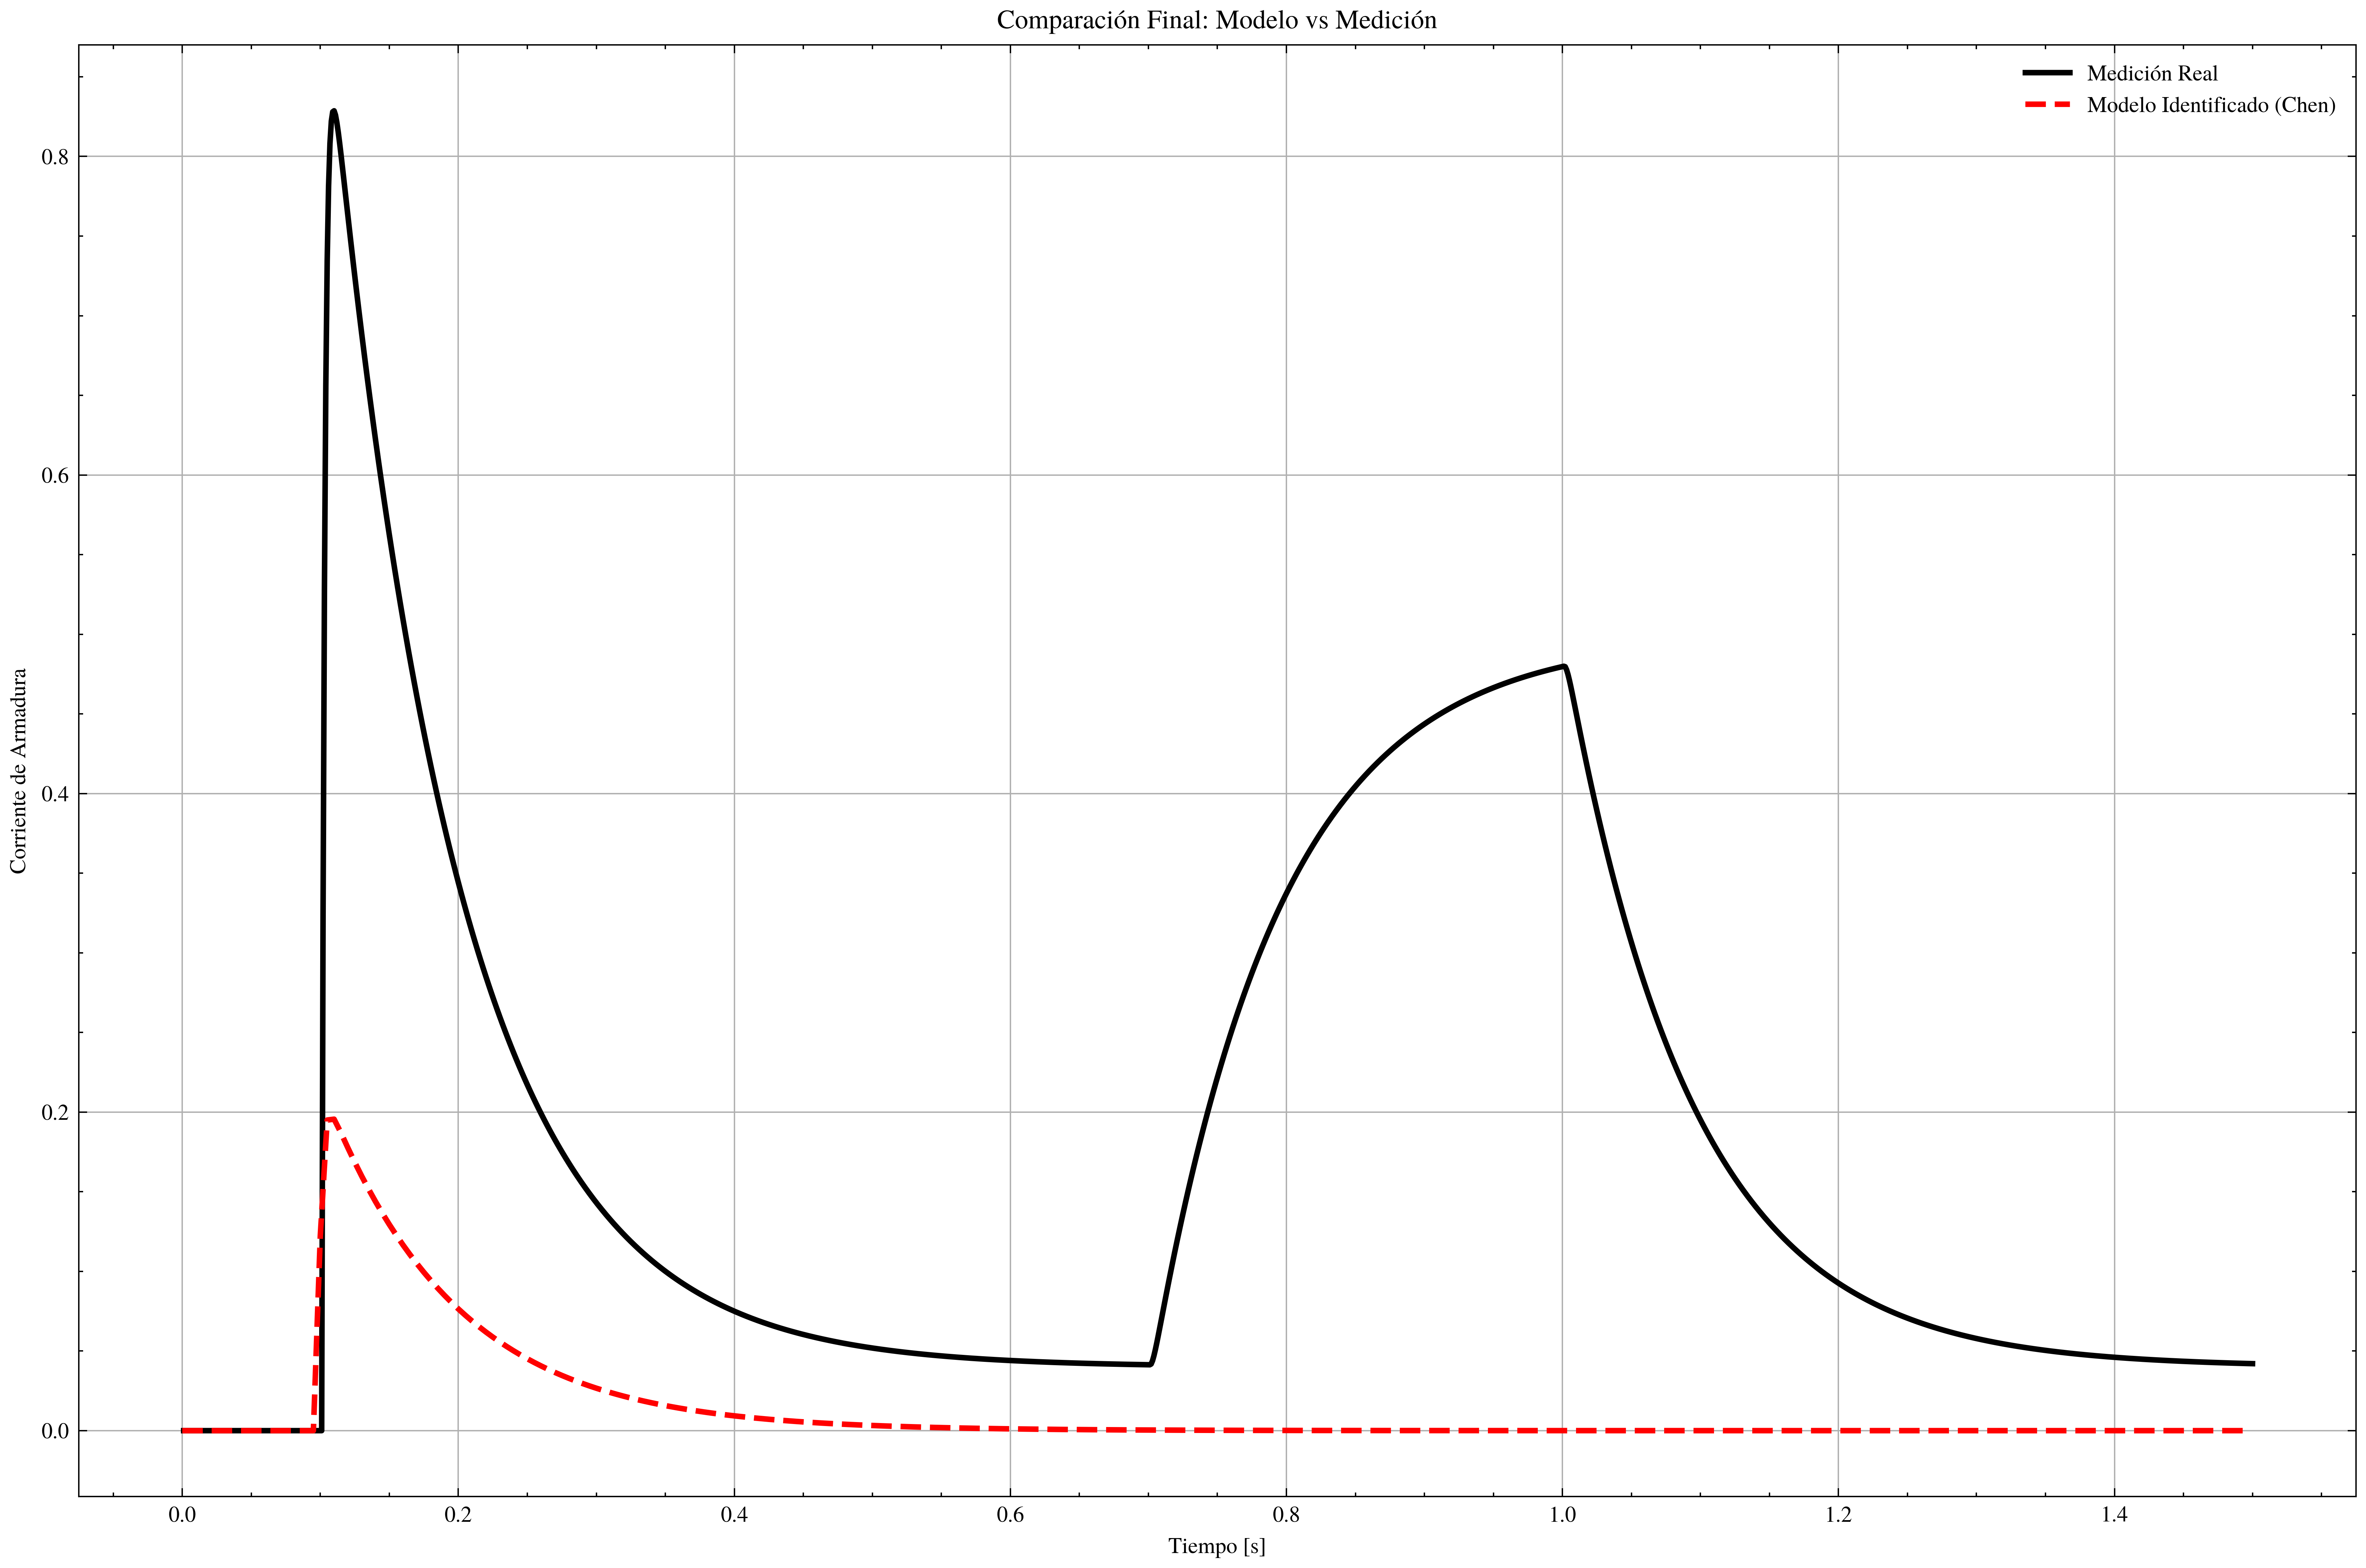

In [158]:
from control.matlab import * #permite escribir igual que en Matlab

y_final_tension = 0.0416014/2;

k, T1, T2, T3 = obtener_parametros_por_metodo_chen(
    tiempos_relativos_tension,
    delay_tension,
    tiempos,
    salidas,
    amplitud_tension,
    y_final_tension
)
# === Mostrar resultados === 
print(f"Corriente/Va:")
print(f"  K = {k:.4f}")
print(f"  T1 = {T1:.6f} s")
print(f"  T2 = {T2:.6f} s")

 
sistemas_i_va = k*TransferFunction([1,0], np.convolve([T1, 1], [T2, 1]))
print(sistemas_i_va)
# Simulamos la salida


t_out, y_tension, _ = lsim(sistemas_i_va,    U=entrada_tension, T=t_sim) 



plt.figure(figsize=(12, 8))
plt.plot(tiempos, salidas, label="Medición Real", linewidth=2)
plt.plot(y_tension, t_out, label="Modelo Identificado (Chen)", linewidth=2)
plt.title("Comparación Final: Modelo vs Medición")
plt.xlabel("Tiempo [s]")
plt.ylabel("Corriente de Armadura")
plt.legend()
plt.grid(True) 
plt.tight_layout()
plt.show()

 

POSTA

Amplitud del escalón: 2
0.08291053053318556

--- PARÁMETROS IDENTIFICADOS ---
Tensión -> Corriente:
  K = 0.0415
  T1 = 0.002647 s
  T2 = 0.085804 s
  T3 = -1.721157 s


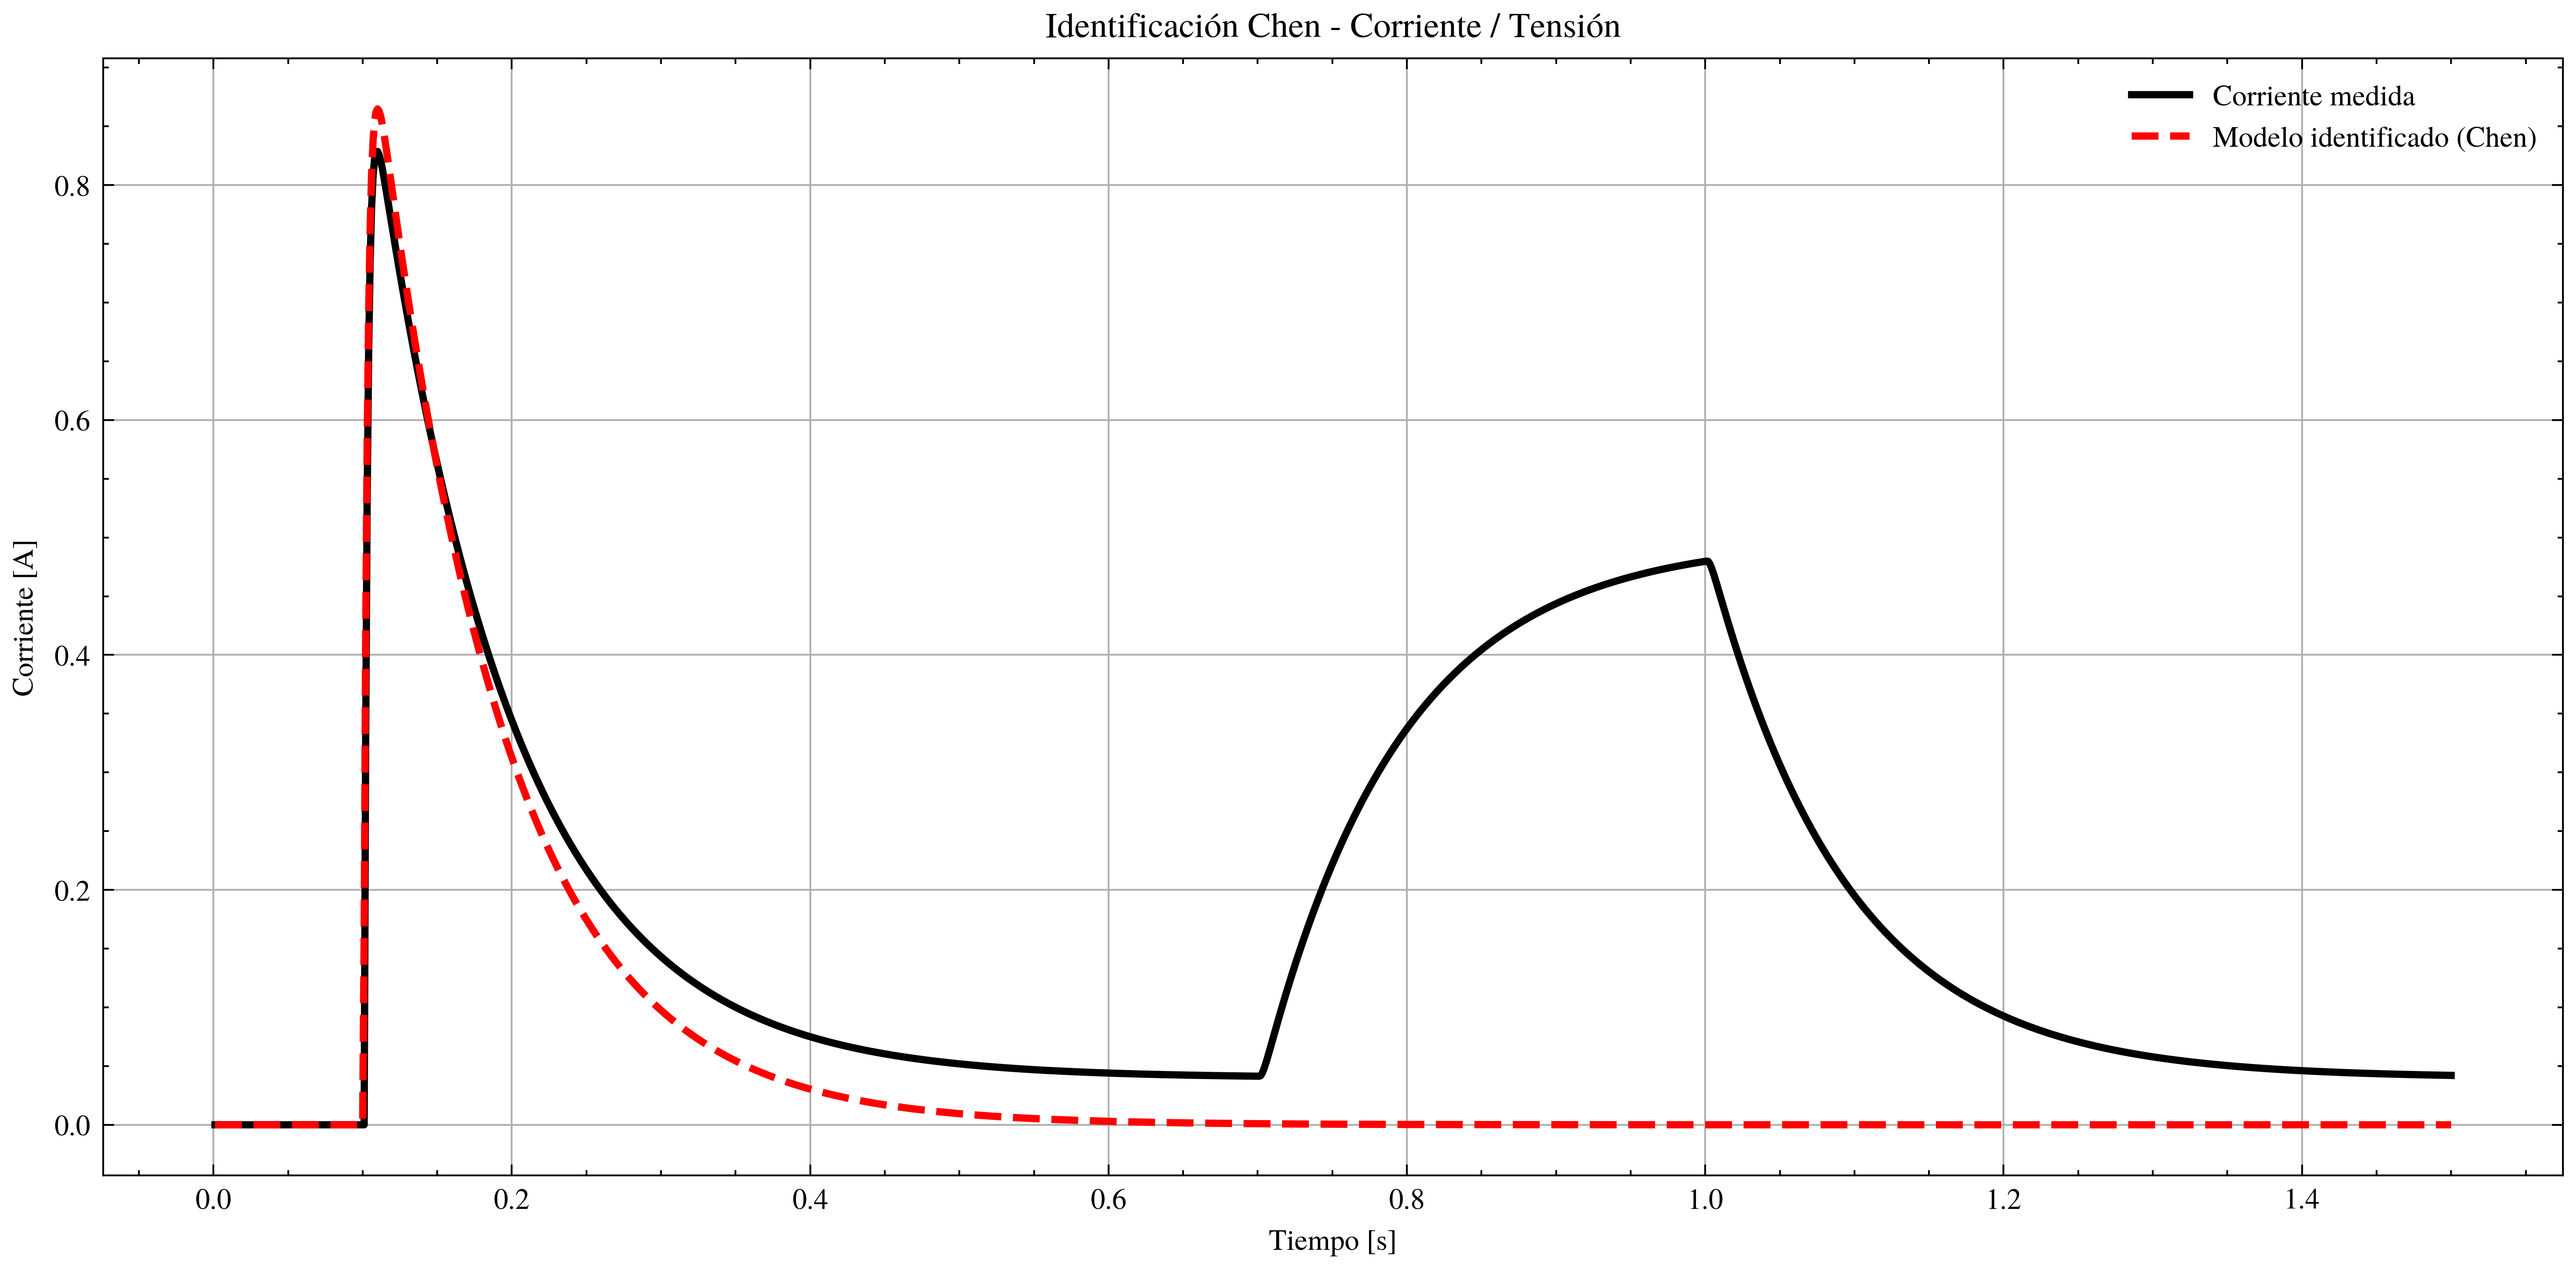

In [174]:
# ========================
# Preparar variables para Corriente vs Tensión
# ========================

# Definir los puntos equidistantes en el tiempo para corriente respecto a tensión
delay_corriente = 0.1  # retardo estimado
t1_rel_corriente = 0.015
tiempos_relativos_corriente = [t1_rel_corriente, 2*t1_rel_corriente, 3*t1_rel_corriente]

# Extraer datos 
corriente = df["Corriente en armadura [A]"]
tension = df["Tensión [V]"]
# Amplitud del escalón de tensión
amplitud_escalon = tension.max()

print(f"Amplitud del escalón: {amplitud_escalon}")

# Estimar valor estacionario de la corriente (ajustar según tu caso)
mask_estacionario_corriente = (tiempos >= 0.69) & (tiempos <= 0.7)
y_final_corriente = corriente[mask_estacionario_corriente].mean()*amplitud_escalon


print (y_final_corriente)

# ========================
# Aplicar método de Chen
# ========================

k_ci, T1_ci, T2_ci, T3_ci = obtener_parametros_por_metodo_chen(
    tiempos_relativos_corriente,
    delay_corriente,
    tiempos,
    corriente,
    amplitud_escalon,
    y_final_corriente
)

# ========================
# Crear función de transferencia
# ========================

from scipy.signal import TransferFunction

sistema_ci = TransferFunction([k_ci,0], np.convolve([T1_ci, 1], [T2_ci, 1]))

# ========================
# Mostrar resultados
# ========================
print("\n--- PARÁMETROS IDENTIFICADOS ---")
print(f"Tensión -> Corriente:")
print(f"  K = {k_ci:.4f}")
print(f"  T1 = {T1_ci:.6f} s")
print(f"  T2 = {T2_ci:.6f} s")
print(f"  T3 = {T3_ci:.6f} s")

# ========================
# Simular y graficar (opcional)
# ========================
from scipy.signal import lsim
import matplotlib.pyplot as plt

t_sim, y_sim, _ = lsim(sistema_ci, U=tension, T=tiempos)

plt.figure(figsize=(10,5))
plt.plot(tiempos, corriente, label='Corriente medida', linewidth=2)
plt.plot(t_sim, y_sim, '--', label='Modelo identificado (Chen)', linewidth=2)
plt.xlabel("Tiempo [s]")
plt.ylabel("Corriente [A]")
plt.title("Identificación Chen - Corriente / Tensión")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



### Ítem [6]
Implementar un PID en tiempo discreto para que el ángulo del motor permanezca en una referencia de **1 radian** sometido al torque descrito en la Fig. 1-3.  
**Tip:** partir de \( K_P = 0.1 \), \( K_I = 0.01 \), \( K_D = 5 \).
